# Project Assignment B:  
This notebook contains the solutions for Project Assignment B of the course 02806 Social Data Analysis and Visualization. It serves as an explainer Jupyter Notebook, documenting all behind-the-scenes data analysis processes. The content includes detailed information about the dataset, the applied methodology, the reasoning behind the selected visualizations, and explanations of the techniques and decisions made throughout the project.

#### Authors 
- *Eva María Benito Sanz - s243313*  
- *Alba Gonzalo Primo - s243343*   
- *Camilla Santoro - s232441*  

#### Date  
*05/05/2025* 

---
## Section 1: Motivation  
---

Our project uses two datasets provided by the NYC Government. The first dataset contains historical PM2.5 air pollution data from 2009 to 2023, including annual, summer, and winter mean concentrations, with a total of 1,863 records. The second dataset provides public health data on asthma-related emergency department visits and hospitalizations from 2003 to 2022, consisting of 760 records across eight variables.

Both datasets include detailed geographical and temporal information, which allows for fine-grained analysis across New York City. The air quality data is reported at the Community District (CD) level, offering local precision with annual and seasonal pollution averages. The health data, on the other hand, is aggregated at the United Hospital Fund (UHF) neighborhood level, slightly broader than community districts, and includes age-adjusted percentages, raw percentages, and estimated case numbers.


We selected these datasets due to their complementary structures, which enable us to extract meaningful spatial and temporal insights. This combination allows us to examine key trends at the intersection of public health and environmental conditions. Specifically, we focus on asthma, a chronic disease significantly influenced by air pollution. By merging air quality and health data, we can conduct a comprehensive analysis of how PM2.5 pollution affects asthma rates over time and across various communities. Furthermore, the detailed granularity at both district and neighborhood levels enables us to assess whether vulnerable or marginalized populations experience a disproportionate impact, as well as whether public policy measures implemented during the study period had a measurable effect.


Our goal for the end user's experience was to guide them through a compelling narrative that illustrates the strong connection between pollution and asthma rates. Using New York City, a major urban center, as a key example, we aimed to highlight how environmental factors directly impact public health, particularly through pollution-induced asthma. By presenting real-world data in an accessible and engaging manner, we wanted users to recognize patterns, understand the social and geographical disparities, and critically assess the effectiveness of past public policies. Through clear explanations and interactive data exploration, our intention was not only for users to absorb key findings, but also to empower them to independently explore the data, uncover insights, and develop a deeper, more informed understanding of the broader implications of environmental health issues on urban communities.

---
## Section 2: Basic stats. Let's understand the dataset better  
---

For this project, we began by searching for two datasets that could be meaningfully compared and that shared the same level of granularity, both in time and geography. After exploring several options, we selected two datasets from the NYC Environmental Health Data Portal: one on adult asthma prevalence and one on fine particulate matter (PM2.5) levels. These datasets provided consistent coverage at both the borough and UHF district ("UHF34") levels, which allowed us to align them for joint analysis. We decided to merge the datasets based on the TimePeriod and geographic columns (e.g., Borough), using an inner join to retain only the records present in both datasets. During this process, we noticed the presence of some missing values (NaNs), but chose not to eliminate them, as doing so would have required dropping entire geographic areas—particularly at the more detailed UHF34 level—which would have weakened our analysis. We also looked for additional datasets to enrich the analysis, but were unable to find others with matching structure and granularity, so we proceeded with these two. In terms of preprocessing, we first filtered each dataset by GeoType, sometimes selecting Borough for higher-level visualizations, and other times UHF34 when we wanted more localized insight. We converted the TimePeriod column to a numeric type using pd.to_numeric with error coercion, and then cast it to integer format. In the asthma dataset, the Percent values were originally strings that sometimes included non-numeric characters, so we used regular expressions to extract and convert them to float values. We also selected only the relevant columns for our analysis and renamed them for clarity—for example, Geography was renamed to Borough and Annual mean mcg/m3 to PM25. Finally, we conducted some preliminary data exploration to inspect the distributions and identify any anomalies before proceeding to the analysis phase. These data cleaning and preprocessing steps ensured a clean and coherent dataset, well-suited for visual and statistical examination of potential relationships between air quality and asthma rates across New York City.

We will now provide some statistics we have observed in the datasets.

The asthma dataset contains annual data on the percentage of adults who reported having asthma in the past 12 months. The data spans multiple years from 2009 to 2022 and includes different geographic resolutions, namely Borough and UHF34 (United Hospital Fund districts). After filtering for relevant geographic types, we focused on the columns TimePeriod, Geography (renamed Region), and Percent (renamed AsthmaPercent).

The cleaned dataset contains 464 valid records with non-null asthma percentages. The mean asthma rate across all years and regions is 4.51%, with a minimum of 0.0% (likely due to missing or anomalous data) and a maximum of 15.3%, indicating substantial variance in asthma prevalence across both time and space. The standard deviation of 2.29% shows a moderate spread, with some regions or time periods showing significantly higher rates than others. This variation suggests that both temporal and geographic factors may play a role in influencing asthma prevalence.

The PM2.5 dataset includes annual measurements of fine particulate matter (µg/m³), a key air quality indicator linked to respiratory issues. Similar to the asthma dataset, it spans 2009 to 2022 and includes both Borough and UHF34 resolutions. After standardizing the TimePeriod and Annual mean mcg/m3 (renamed PM25), we retained only the essential columns.

The PM2.5 dataset has 546 records, all with valid numeric values. The average PM2.5 level is 8.33 µg/m³, with values ranging from 5.0 to 13.9 µg/m³. The standard deviation is 1.76, suggesting notable variation, although most values cluster between 6.8 and 9.6 µg/m³ (the 25th and 75th percentiles, respectively). The data reveals a gradual decline in PM2.5 levels over time, reflecting ongoing environmental policy efforts to improve air quality in NYC.

The merged dataset includes records from both sources matched on TimePeriod and Region, restricted to entries with the same geographic type (either Borough or UHF34).

Preliminary analysis of the merged dataset shows distinct patterns. For example, boroughs like The Bronx often exhibit higher asthma rates, while also having had historically higher PM2.5 levels, raising questions about long-term environmental exposure and its health impacts. Conversely, boroughs such as Manhattan or Staten Island typically show lower asthma prevalence and declining PM2.5 trends over the years.

Line plots created from the merged dataset visualize these dynamics clearly:

- The asthma trend plot reveals spatial variability, with some boroughs consistently reporting higher asthma percentages over time.
- The PM2.5 trend plot confirms a citywide improvement in air quality, though disparities remain between regions.

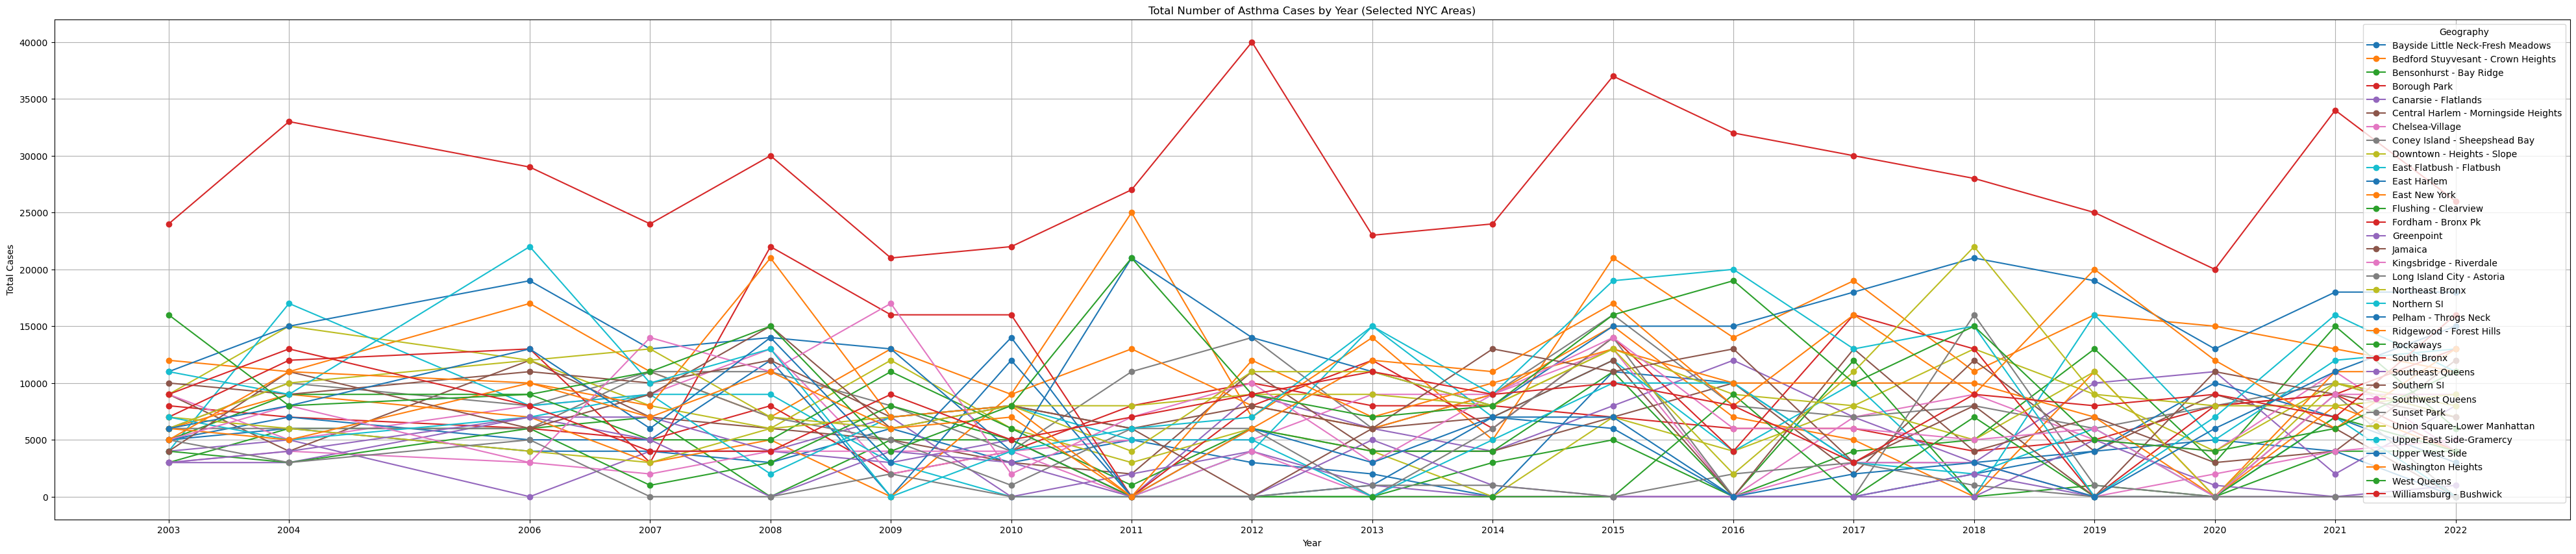

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# 1. Read your CSV
df = pd.read_csv("NYC EH Data Portal - Adults with asthma (past 12 months) (full table).csv")


# 1. Converti TimePeriod in numero e arrotonda all'anno più vicino
df["TimePeriod"] = pd.to_numeric(df["TimePeriod"], errors="coerce").round(0).astype(int)

df = df[df["GeoType"] == "UHF34"]


# 3. Pulisci la colonna "Number" per estrarre il valore numerico
def extract_number(s):
    if pd.isna(s):
        return None
    s_clean = re.sub(r"[,\*]", "", s.strip())  # rimuove virgole e asterischi
    try:
        return float(s_clean)
    except ValueError:
        return None

df["TotalCases"] = df["Number"].apply(extract_number)

# 4. Fai il pivot in modo che ogni Geography sia una colonna distinta
df_pivot = df.pivot_table(
    index="TimePeriod",
    columns="Geography",
    values="TotalCases",
    aggfunc="sum"  # usa "sum" (o "mean") nel caso ci siano più righe per anno
)

# 5. Crea il grafico a linee
plt.figure(figsize=(50, 10))
for geo in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[geo], marker="o", label=geo)

plt.title("Total Number of Asthma Cases by Year (Selected NYC Areas)")
plt.xlabel("Year")
plt.ylabel("Total Cases")
plt.legend(title="Geography")
plt.grid(True)

# Se vuoi forzare i ticks dell'asse X a essere solo interi
all_years = df_pivot.index.tolist()
plt.xticks(all_years, all_years)

plt.show()


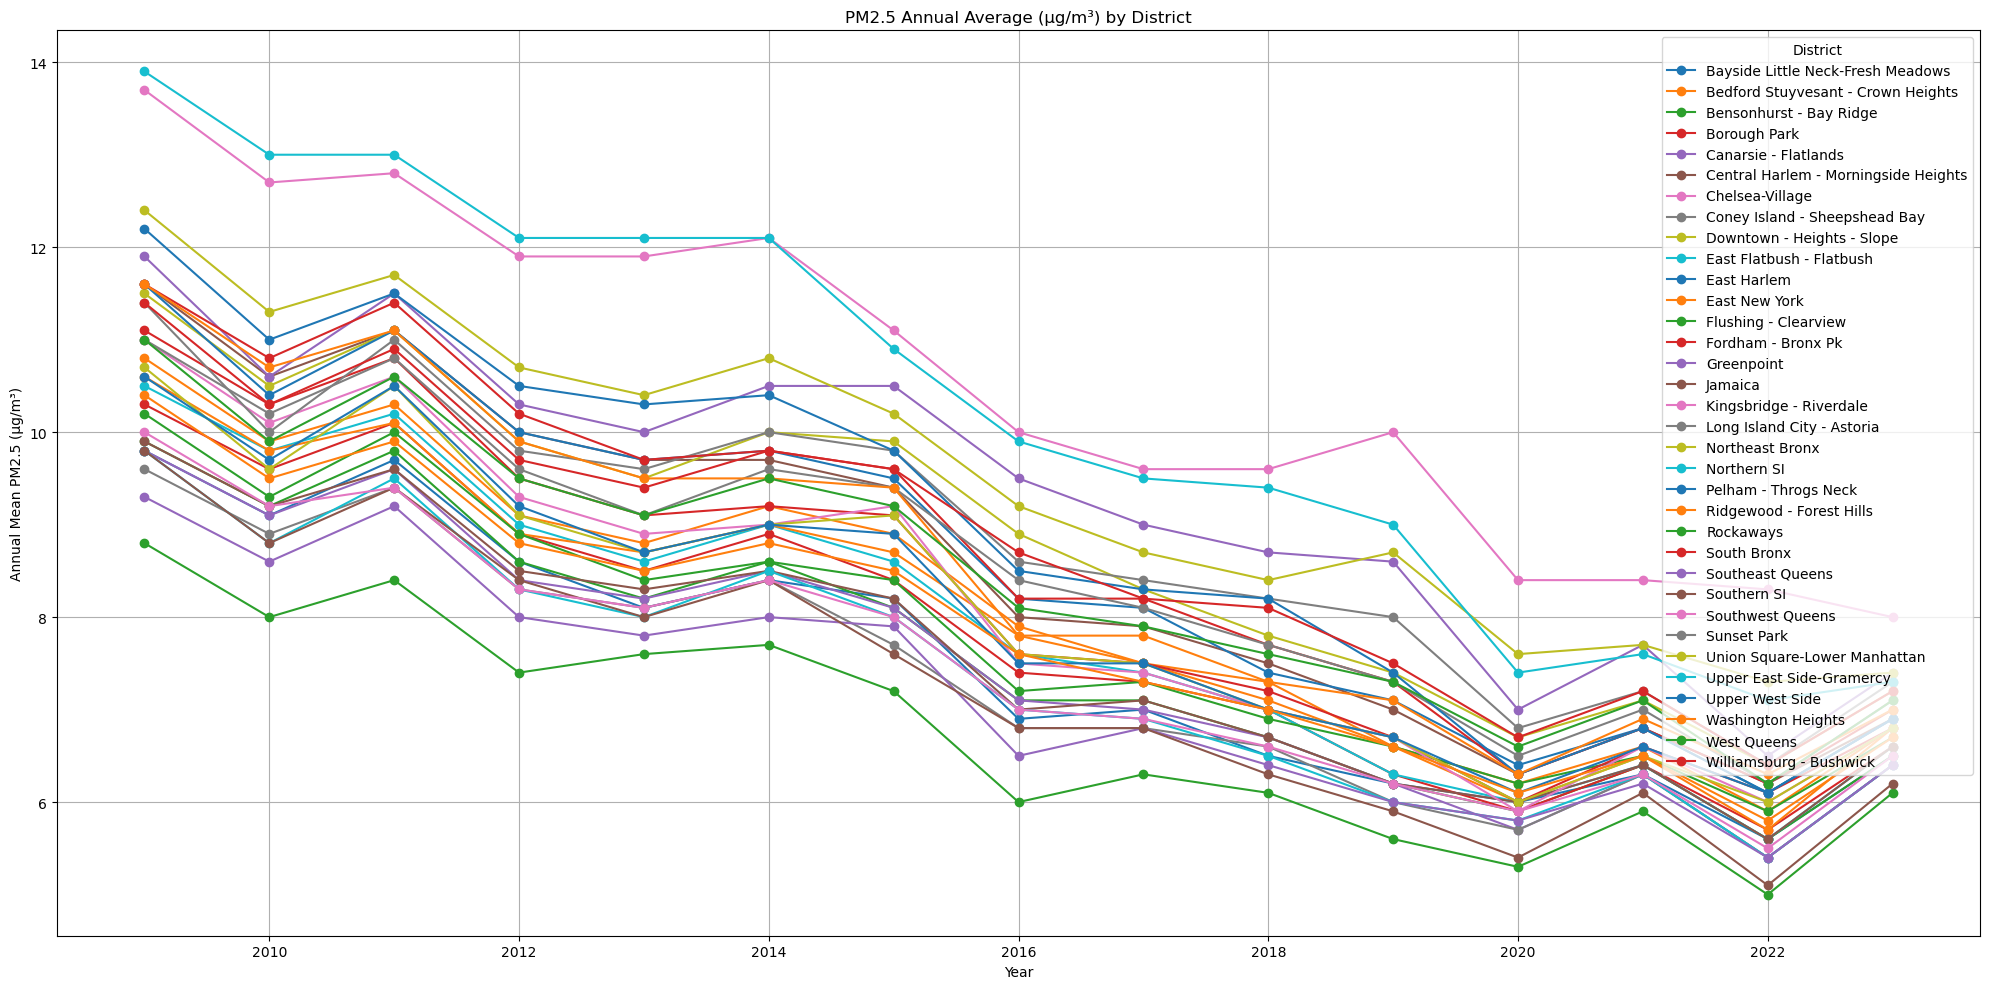

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carica il dataset
df = pd.read_csv("NYC EH Data Portal - Fine particles (PM 2.5) (full table).csv")

# 2. Filtra per GeoType == 'Borough'
df = df[df["GeoType"] == "UHF34"]

# 3. Seleziona solo le colonne utili
df = df[["TimePeriod", "Geography", "Annual mean mcg/m3"]]

# 4. Pulisci i dati
df["TimePeriod"] = pd.to_numeric(df["TimePeriod"], errors="coerce").astype("Int64")
df["Annual mean mcg/m3"] = pd.to_numeric(df["Annual mean mcg/m3"], errors="coerce")

# 5. Pivot per line chart
df_pivot = df.pivot(index="TimePeriod", columns="Geography", values="Annual mean mcg/m3")

# 6. Crea il grafico
plt.figure(figsize=(20, 10))
for borough in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[borough], marker="o", label=borough)

plt.title("PM2.5 Annual Average (µg/m³) by District")
plt.xlabel("Year")
plt.ylabel("Annual Mean PM2.5 (µg/m³)")
plt.grid(True)
plt.legend(title="District")
plt.tight_layout()
plt.show()


---
## Section 3: Data Analysis  
---

In the preliminary phase of the study, the analysis focused on broader trends across the five boroughs—Manhattan, Brooklyn, Bronx, Queens, and Staten Island. Following feedback from the first project presentation (Assignment A), which suggested providing more granular insights, the methodology was refined by adopting the United Hospital Fund (UHF34) division, partitioning NYC into 34 neighborhoods. This change allowed for a more detailed and localized examination of air quality and health outcomes.

The analysis of PM2.5 annual average concentrations from 2009 to 2023 revealed a clear and consistent downward trend across all boroughs. Most districts showed a steady decline, with some fluctuations around the years 2014 to 2016, followed by a sharper decrease particularly after 2018. This latter drop coincides with the COVID-19 pandemic, during which restrictions on activities likely contributed to lower emissions. Despite these overall improvements, certain areas consistently exhibited higher PM2.5 concentrations, suggesting the presence of persistent localized sources of pollution. Chelsea Village emerged as one such example, with PM2.5 levels consistently above the citywide average, and although it was not the area recording the highest number of asthma cases but it is close to Brooklyn, a bourogh that have always had the highest number of asthma cases all over the years. Several factors could explain Chelsea’s elevated pollution levels, including heavy traffic congestion due to its proximity to major roadways such as the West Side Highway and 14th Street, emissions from dense residential and commercial buildings using fossil fuel-based heating systems, and legacy pollutants from its industrial past.

When comparing the trends in asthma cases over time, a much more volatile pattern emerged. Unlike the steady decline observed in PM2.5 concentrations, asthma case numbers fluctuated significantly from year to year across the boroughs. Manhattan consistently reported the highest level of 2.5pm over the period studied, while Staten Island maintained the lowest rates. Nevertheless, a closer examination of the data reveals an important observation: in several areas, following a significant decrease in PM2.5 levels, a similar decreasing trend in asthma cases tends to appear after approximately four years. This delayed response suggests that while environmental improvements do eventually contribute to better respiratory health outcomes, the effect is not immediate and may require a few years to become evident at the population level.

Several factors could account for the complex and sometimes counterintuitive relationship between air quality and asthma rates. Indoor air quality, often affected by housing conditions such as the presence of mold or indoor allergens, plays a critical role in respiratory health and may continue to drive asthma prevalence even as outdoor air becomes cleaner. Socioeconomic factors also have a substantial impact, as access to healthcare, differences in economic stability, and population demographics vary widely across NYC neighborhoods, influencing the diagnosis, reporting, and management of asthma. In addition, urbanization and population density contribute to borough-level differences: Staten Island, for instance, is characterized by suburban-style neighborhoods, lower population density, and abundant green spaces, with only 8,618.3 residents per square mile compared to Manhattan’s 72,918. In contrast, Brooklyn and the Bronx, both more densely populated and subject to greater industrial and traffic-related pollution, consistently showed higher asthma rates alongside higher pollution levels.

---
## Section 4: Genre. Which genre of data story did you use?  
---

For this project, we chose a slideshow-style narrative. This format structures the content into clear, digestible sections, effectively guiding the audience through our story using visual aids to highlight key findings. Additionally, the incorporation of interactive graphs encourages the audience to explore the data further on their own, reinforcing our findings and allowing them to draw their own, more detailed conclusions.

#### 1. Which tools did you use from each of the 3 categories of Visual Narrative? Why?

Segal and Heer’s **Visual Narrative Tools** fall into three key categories, each playing a role in shaping how users process and interact with data.

##### A. Visual Structuring

Our website utilizes:  
- **“Checklist” Progress Tracker**: While not a checklist in the traditional sense, our interface is designed with distinct slides—introduction, health impact, hotspots, and solutions (policies), all related to the central theme of air pollution and asthma in NYC. We can consider this a progress tracker, guiding users through each slide toward completion. This separation ensures clarity and prevents cognitive overload by breaking the information into manageable segments.
- **Consistent Visual Platform**: The website maintains a uniform aesthetic across all slides (pages), reinforcing coherence and making transitions seamless. We use a consistent color theme, as well as standardized buttons, plots, and text containers.

**Why?**  
These tools ensure an intuitive and logical visual flow, helping users absorb complex environmental and health data efficiently. Without a clear and consistent structure, users might feel distracted or overwhelmed and fail to engage fully with the content.

##### B. Highlighting

Our website incorporates:  
- **Close-Ups**: Throughout the website, multiple buttons allow users to interact and view detailed information through pop-ups. We designed these interactive elements to reduce visual clutter while still providing deeper insights.
- **Feature Distinction**: When users modify parameters, graphs update with smooth transitions rather than abrupt changes, creating a visually engaging experience.
- **Character Direction**: Although our website is a slideshow with many interactive elements, we subtly guide users’ attention toward specific information to maintain a coherent narrative flow.

**Why?**  
Interactive animations encourage active engagement, helping users visualize the data we want them to focus on. Close-ups, for example, often spark user curiosity and make it easier to stay engaged with the story.

##### C. Transition Guidance

Our website leverages:  
- **Viewer (Camera) Motion**: Smooth transitions between slides help users move naturally between sections without being jarred by sudden changes.
- **Object Continuity**: We carefully ensure that visuals remain consistent throughout the website, maintaining the same color theme, using the same plotting framework (Bokeh), and applying uniform fonts and containers.
- **Animated Transitions**: We use various animations, such as fades when changing slides, zooms for pop-ups, and dynamic button color changes upon interaction.

**Why?**  
Transition guidance makes statistical insights more digestible and emotionally resonant by ensuring the entire journey feels smooth and cohesive.

---

#### 2. Which tools did you use from each of the 3 categories of Narrative Structure? Why?

The **Narrative Structure** elements reinforce storytelling and guide users through their data driven journey.

##### A. Ordering & Navigation

Our dashboard employs:  
- **User-Directed Path**: Instead of forcing a linear story, users control their experience by interacting with multiple variables at their own pace. They can draw their own conclusions depending on how they interact with different plots or pop-ups. However, the slideshow maintains an overall narrative order that we encourage users to follow, while always allowing them to revisit previous slides freely.

**Why?**  
This approach maintains flexibility, allowing users to explore the insights that matter most to them.

##### B. Interactivity

We implemented:  
- **Hover Highlighting / Details**: Hover effects allow deeper exploration. Elements like plots reveal additional insights when hovered over, helping users discover underlying information without cluttering the main interface. Some containers are also highlighted or shadowed to draw attention.
- **Filtering / Selection / Search**: Plots allow users to toggle the visibility of certain data, filter information, or search specific years. These features enable highly personalized and dynamic exploration.
- **Navigation Buttons**: We provide two navigation methods: (1) top navigation buttons indicating the different slides, and (2) left/right arrow buttons at the page center to move sequentially through slides without needing to think about their order.
- **Tacit Tutorial**: We provide pop-ups and descriptions that detail the features of plots and explain how to interpret specific insights or parameter choices.

**Why?**  
Interactivity ensures deeper engagement, making users active participants in discovering how pollution affects health.

##### C. Messaging

Our dashboard employs:  
- **Captions / Headlines**: Sections such as *“Breathing NYC’s Air”* concisely explain air pollution dangers before introducing interactive elements. Each slide also has a clear headline to orient and engage users.
- **Annotations Translating Abstract Data into Real-World Terms**: For example, the cigarette-equivalence analogy helps users understand the seriousness of PM2.5 exposure through familiar concepts.
- **Accompanying Articles**: Each slide (tab) links to supporting external articles, providing scientific explanations that back our observations and conclusions.
- **Comment Repetition**: We reinforce key concepts throughout the website, helping users retain important ideas by re-encountering them at different points.
- **Introductory Text**: Each slide includes introductory text beneath the headline to set the context and prepare users for the upcoming information.
- **Summary or Synthesis**: We include summaries throughout the website to maintain user engagement and help sustain their focus.

**Why?**  
Messaging tools enhance accessibility by ensuring users can understand complex environmental risks without needing specialized expertise.

---
## Section 5: Visualizations  
---

For the “Introduction” page, we selected a line chart that displays the trend of PM2.5 levels from 2009 to 2022 across the five boroughs of New York City. Each borough is represented with a distinct color, and a legend helps the viewer identify them. This visualization is ideal for setting the stage, as it introduces the central theme of air pollution in a clear and engaging way. The downward trend of all lines visually reinforces the fact that PM2.5 concentrations have significantly decreased over time. However, it also invites reflection, as many of the values remain close to the U.S. annual limit of 12 μg/m³ for a long period, raising questions about the long-term impact on respiratory conditions like asthma—an issue we explore further throughout the website.

To understand the relationship between air pollution and asthma hospitalizations in New York City, in the “Health Impact” page, we chose an interactive time series plot that aligns both variables over the period from 2008 to 2022. This visualization is particularly suited to the story we want to tell for several key reasons. Rather than presenting raw PM2.5 levels—which can be abstract and hard to interpret for a general audience—we translated pollution into the more relatable metric of cigarettes smoked per day. Most people have an immediate sense of how harmful smoking is, so framing pollution this way eliminates guesswork and makes the health risks more tangible. By plotting pollution (as purple bars) alongside normalized asthma hospitalization rates (as an orange line), the visualization allows users to see potential correlations at a glance. Normalization was essential here, since both variables originally used different units and scales. Standardizing them enables users to focus on the relationship and temporal trends, rather than the raw magnitudes. Respiratory effects from pollution are rarely immediate, so to help explore this, we included a slider that lets users shift the asthma trend horizontally, simulating a delayed response to pollution exposure. This feature invites exploration and hypothesis-building—for example, seeing whether pollution spikes are followed by increases in asthma hospitalizations a year or two later. Users can toggle the visibility of each data layer (pollution or asthma), hover to view exact values, and decide whether to show cigarette-equivalent numbers above each bar. This flexibility enhances engagement while keeping the interface clean and accessible. In short, this visualization combines relatable framing, temporal alignment, and interactive tools to let users explore and interpret the relationship between air pollution and asthma in a nuanced, evidence-based way. We believe it’s the most effective approach for revealing how environmental health disparities evolve over time in NYC.

For the “Hotspots” page, we decided to choose a map-based visualization because it offers a more intuitive and geographically grounded way to understand how pollution and asthma affect different neighborhoods across New York City. Our goal was to move beyond abstract numbers and enable users to visually connect environmental health issues to specific places. These map visualizations empower users to explore both the progress achieved and the persistent inequities in air pollution and asthma outcomes across the city. The Constant Scale view is particularly effective for illustrating long-term improvements. Since the pollution scale remains fixed, it clearly highlights neighborhoods that have experienced significant air quality gains over time, gains that, as we will later explore, are largely the result of effective environmental policies and targeted solutions. In contrast, the Yearly Reset Scaling view is essential for revealing ongoing disparities. By resetting the pollution scale each year, this visualization brings attention to the neighborhoods that consistently suffer from the highest levels of pollution, even as overall citywide conditions improve. It underscores the reality that not all communities benefit equally from environmental progress. Lastly, the Socio-Economic Layer Toggle deepens the narrative by exposing the intersection of environmental and social inequality. By visually fading out wealthier neighborhoods, this feature directs focus toward the communities most affected by poor air quality and asthma, often low-income and historically marginalized populations.

For the "Solutions" page, we chose a line chart, this time representing the overall PM2.5 levels in New York City from 2009 to 2022 without breaking them down by borough. The chart includes colored markers along the line, each corresponding to a specific policy or initiative aimed at reducing air pollution—such as the 2014 Air Pollution Control Code—as explained in the legend. This visualization is particularly effective for our narrative because it allows users to explore the timeline of implemented solutions and visually correlate them with changes in PM2.5 levels. By hovering over the chart, users can access the exact PM2.5 values for each year, while the placement of the markers makes it easy to identify when a particular measure was adopted. This interactive design supports our goal of highlighting the potential impact of specific interventions on air quality.

---
## Section 6: Discussion  
---

---
## Contributions  
---

| Element            | Responsible       |
|:-------------------|:------------------|
| Web Design         | Eva               |
| Storytelling       | Alba              |
| Data Analysis & Processing| Camilla           |   
| Web implementation | Eva               |
| Slider Introduction & Plot | Camilla           |
| Slider Health & Plot | Eva               |
|Slider Hotspots & Plot | Alba           |
| Slider Solutions & Plot | Camilla              |
| Jupyter Section 1 & 6 | Alba              |
| Jupyter Section 2, 3 & 5| Camilla              |
| Jupyter Section 4 & References| Eva               |


---
## References  
---

> Source: E. Segel and J. Heer, "Narrative Visualization: Telling Stories with Data," in IEEE Transactions on Visualization and Computer Graphics, vol. 16, no. 6, pp. 1139-1148, Nov.-Dec. 2010, [doi: 10.1109/TVCG.2010.179](https://doi.org/10.1109/TVCG.2010.179).


> Source: [Air Pollution and Cigarette Equivalence in **Berkeley Earth by Richard A. Muller and Elizabeth A. Muller**](https://berkeleyearth.org/air-pollution-and-cigarette-equivalence/)

> Source: [Impact of PM2.5 on asthma ER visits.](https://link.springer.com/article/10.1007/s11356-015-5321-x)

> Source: **Gauderman et al. (2015)**, NEJM: [Cleaner air improves lung growth and reduces asthma](https://www.nejm.org/doi/full/10.1056/NEJMoa1414123)

> Source: **Zheng et al. (2015)**, PLoS One: [PM2.5 increases asthma ER visits and hospitalizations](https://doi.org/10.1371/journal.pone.0138146)

> Source: **Liu et al. (2019)**, NEJM: [PM2.5 linked to increased respiratory mortality in adults](https://www.nejm.org/doi/full/10.1056/NEJMoa1817364)
> Source: [Inequitable Exposure to Vehicle Pollution in New York](https://www.ucs.org/sites/default/files/attach/2019/06/Inequitable-Exposure-to-Vehicle-Pollution-NY.pdf)

> Source: [EPA Study: Air Pollution Higher for People of Color](https://www.epa.gov/sciencematters/study-finds-exposure-air-pollution-higher-people-color-regardless-region-or-income)

> Source: [Center for the Humanities: Air, Heat & Climate Data](https://centerforthehumanities.org/air-heat-climate-data/)

> Source: [NYC Community Health and Air Pollution Report](https://nyc-eja.org/wp-content/uploads/2024/06/NYC_CHAMPEJ_Report.pdf)

> Source: [asthma rates in the Bronx](https://www.cbsnews.com/newyork/news/bronx-asthma-rates-environmental-justice/)

> Source: [environmental racism in the Bronx](https://pix11.com/news/created-equal/environmental-racism-in-the-bronx-why-the-asthma-rate-is-so-high-in-the-borough/)

> Source: [NYC Clean Heat Program](https://pmc.ncbi.nlm.nih.gov/articles/PMC6023219/) — The NYC Clean Heat Program targeted the phase-out of highly polluting No. 6 fuel oil, significantly decreasing wintertime ambient PM2.5 concentrations.

> Source: [Clean Transport Standards](https://www.sciencedirect.com/science/article/pii/S135223102100056X)

> Source: [Air Pollution Control Code (2014)](https://www.nyc.gov/office-of-the-mayor/news/165-14/on-earth-day-mayor-de-blasio-city-council-plans-biggest-to-city-s-air#/0)

> Source: [COVID-19 and Emerging Measures](https://a816-dohbesp.nyc.gov/IndicatorPublic/data-stories/air-quality-and-covid-part-2/)
